The cell below installs the required Python packages for this notebook.

In [1]:
%pip install sklearn pandas numpy kaggle

Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:
# Scikit-learn
from sklearn.datasets import fetch_california_housing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.naive_bayes import GaussianNB

# Data manipulation and math
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import math
from zipfile import ZipFile

# Visualization
import matplotlib.pyplot as plt

# How can group and individual fairness notions be satisfied, and how do they affect the performance of a machine learning model?
In this section we will explore how group and individual fairness notions affect the performance of a machine learning model. First, we motivate this research questions by contextualizing its relevance in problems of machine learning. We discuss each notion separately. Then, we briefly look at the theoretic background of these notions and predict the expected performance. We conclude by putting these notions to the test.

## Motivation
Machine learning applications are increasingly being applied in the industry. Legislators, insurers and banks are playing catch-up to integrate this technology in the process of decision-making. Supervised learning often relies on historical data. This means that bias present in the data is transferred to the model. Perpetuating this bias is not only unfair, but often unlawful or contrary to company policy. Chouldechova & Roth (2018) identify three causes of unfairness:
* **Bias in training data**: historical data that has human bias embedded in it. A classic example is the disproportionate amount of crime committed by some marginalized and ostracized communities. However, this can often be explained by considering the socio-economic situation. Also, these areas might be policed at a higher rate, which further skews crime-prediction models.
* **Minimizing average error**: a majority group will be more accurately represented in a model than a minority group. Naturally, it follows from the fact that the majority group has a larger representation and thus minimizing errors will benefit more if the error of each individual has the same weight.
* **Related to exploration**: online learning models that gets updated with new information while being used, can greatly benefit from the information gained of taking suboptimal decisions. This can be either amoral (e.g. for medical procedures) or benefit/disadvantage certain groups.

Different fairness notions have been introduced in the literature to mitigate problems like these. Knowing which notion to satisfy, depends on the problem at hand.

## Fairness notions
We will now introduce the fairness notions that is going to be applied.

### Statistical parity
There exists different group fairness notions (see Barocas et al., 2017 for an extensive list). Group fairness notions seek to be fair for a protected group. In this work, we only consider **statistical parity** (also known as demographic parity). It is satisfied for a given (sensitive) group attribute when the *positive* classification distribution for each group is identical to that of the entire population (Barocas et al., 2017). This means that predictions needs to be statistically independent with respect to the group attribute. For a sensitive attribute $S$ (with $p$ a protected subgroup) and attribute to predict $Y$ (with $+$ deemed a *positive* prediction) from dataset $X$, it must hold that for any sample $\vec{x} \in X$:
$$\mathbb{P}(\vec{x}(Y) = + \mid \vec{x}(S) = p) = \mathbb{P}(\vec{x}(Y) = + \mid \vec{x}(S) \ne p)$$

Simply removing the sensitive features from the dataset (so called *unawareness*) does not generally lead to satisfying this fairness notion. Moreover, there often exist (a combination of) proxy features. E.g., gender or ethnicity have a high correlation with income in some contexts.

The supervised learning problem is transformed in a multiobjective optimization problem. The two optimization goals become:
* Minimizing the dependency between $S = p$ and $Y$.
* Maximizing the accuracy of predictions $Y$.

A way of quantifying the dependency was proposed by Calders et al. (2009). It corresponds to taking the difference in positive prediction rates of both groups on a dataset $X$:
$$\operatorname{dep}_{S=p}(X) := \frac {|\{\vec{x} \in X \mid \vec{x}(S) \ne p, \vec{x}(S) = +\}|} {|\{\vec{x} \in X \mid \vec{x}(S) \ne p\}|} - \frac {|\{\vec{x} \in X \mid \vec{x}(S) = p, \vec{x}(S) = +\}|} {|\{\vec{x} \in X \mid \vec{x}(S) = p\}|}$$

### Fairness through awareness
As opposed to statistical parity, **fairness through awareness** is an individual fairness notions: it does not look at a sensitive property in particular. Individual fairness is satisfied when similar individuals are classified similarly, in proportion to their degree of similarity. Fairness through awareness accomplishes this with a distance metric $d$ to quantify similarity between individuals and a distance metric $D$ to compare the difference between distributions. The fairness notion is satisfied for a classifier $M$ if it satisfies the $(D, d)$-**Lipschitz property** (Dwork et al., 2012). It entails that for any two individuals $\vec{x}, \vec{y} \in X$:
$$D(M(\vec{x}), M(\vec{y})) \le d(\vec{x}, \vec{y})$$

## Datasets
### Credit card approval
For this research question we will be using two different datasets. The first is a dataset on credit card approval of customers (Dua & Graff 2019). It has already been cleaned, and missing values have been filled (potentially contributing to the bias). The sensitive features include ethnicity and gender. We use this dataset to satisfy statistical parity. We download the dataset, loads it and shows the first 10 entries.

In [3]:
!kaggle datasets download -p data samuelcortinhas/credit-card-approval-clean-data

credit_zip = ZipFile('data/credit-card-approval-clean-data.zip')
credit_df = pd.read_csv(credit_zip.open('clean_dataset.csv'))
credit_df.head(10)

credit-card-approval-clean-data.zip: Skipping, found more recently modified local copy (use --force to force download)


,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.250,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.040,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.500,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.750,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.710,1,0,0,0,ByOtherMeans,120,0,1
5,1,32.08,4.000,1,1,CommunicationServices,White,2.500,1,0,0,1,ByBirth,360,0,1
6,1,33.17,1.040,1,1,Transport,Black,6.500,1,0,0,1,ByBirth,164,31285,1
7,0,22.92,11.585,1,1,InformationTechnology,White,0.040,1,0,0,0,ByBirth,80,1349,1
8,1,54.42,0.500,0,0,Financials,Black,3.960,1,0,0,0,ByBirth,180,314,1
9,1,42.50,4.915,0,0,Industrials,White,3.165,1,0,0,1,ByBirth,52,1442,1


The approval rates for the different genders and ethnicities are interesting properties, as these features are sensitive. The rate of each sensitive feature with the overall rate is visualized using a bar charts below. Each subgroup has the count of the approved group members on top of the bar.

In [4]:
# gets the rate of positive classifications of each sensitive subgroup
def sensitive_rate_df(df_x, df_y, positive):
    df = pd.DataFrame({
        'x': df_x.reset_index(drop=True),
        'y': df_y.reset_index(drop=True)
    })
    return df.groupby('x') \
             .agg(
                 TotalCount=('y', len),
                 Proportion=('y', lambda g: len(g) / len(df)),
                 PositiveCount=('y', lambda g: g.value_counts()[positive]),
                 PositiveRate=('y', lambda g: g.value_counts()[positive] / len(g))
             )

# plots the positive classification reate of each sensitive subgroup
def sensitive_rate_plot(df_x, df_y, positive, title):
    avg_pos = (df_y == positive).sum() / len(df_y)
    sens_rate = sensitive_rate_df(df_x, df_y, positive)

    fig, ax = plt.subplots()
    bars = ax.bar(sens_rate.index, sens_rate['PositiveRate'])

    ax.bar_label(bars, labels=sens_rate['PositiveCount'])

    ax.set_title(f'{title}, (N = {len(df_x)})', fontsize=16)
    ax.set_xlabel(df_x.name, fontsize=12)
    ax.set_xticks(df_x.unique())
    ax.set_ylabel(f'{df_y.name} rate', fontsize=12)
    ax.axhline(y=avg_pos, linewidth=1, linestyle=':', color='r', label='Overall rate')
    ax.annotate(
        f'{avg_pos:.2f}', 
        xy=(1, avg_pos), 
        xytext=(10, 0),
        xycoords=('axes fraction', 'data'),
        textcoords='offset points',
        va='center',
        color='r'
    )
    ax.legend(loc='lower right')
    plt.show()

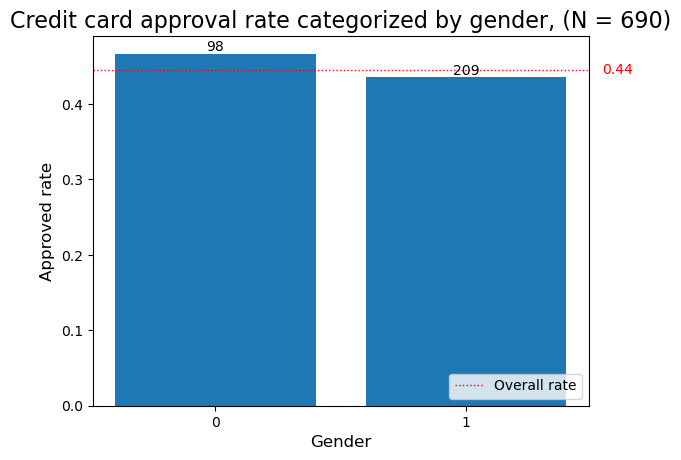

In [5]:
sensitive_rate_plot(
    credit_df['Gender'],
    credit_df['Approved'],
    1,
    'Credit card approval rate categorized by gender',
)

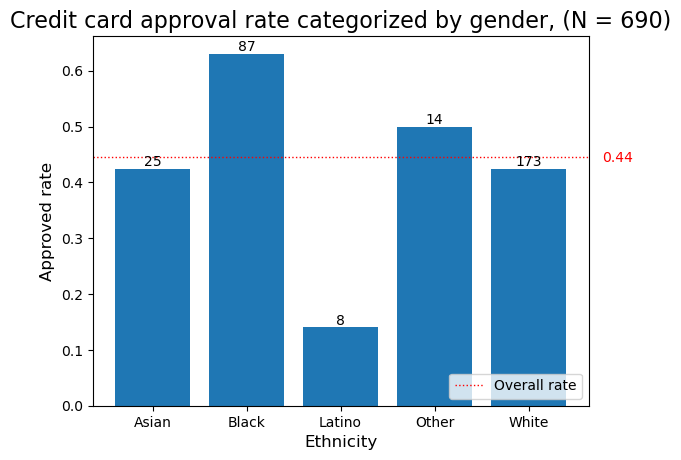

In [6]:
sensitive_rate_plot(
    credit_df['Ethnicity'],
    credit_df['Approved'],
    1,
    'Credit card approval rate categorized by gender',
)

We clearly see that approval rates are not consistent across groups, especially for ethnicity. We perform a $\chi^2$-test to test for dependence ($H_A$) with significance level $\alpha = 0.05$, both between gender and approval, and ethnicity and approval.

In [7]:
gender_contingency = pd.crosstab(index=credit_df['Gender'], columns=credit_df['Approved'])
gender_chi2_res = chi2_contingency(gender_contingency)
print(f'GENDER: X^2 = {gender_chi2_res.statistic:.2f}; p = {gender_chi2_res.pvalue:.2}; N = {len(credit_df)}; df = {gender_chi2_res.dof}')

ethnicity_contingency = pd.crosstab(index=credit_df['Ethnicity'], columns=credit_df['Approved'])
ethnicity_chi2_res = chi2_contingency(ethnicity_contingency)
print(f'ETHNICITY: X^2 = {ethnicity_chi2_res.statistic:.2f}; p = {ethnicity_chi2_res.pvalue:.2}; N = {len(credit_df)}; df = {ethnicity_chi2_res.dof}')

GENDER: X^2 = 0.46; p = 0.5; N = 690; df = 1
ETHNICITY: X^2 = 41.81; p = 1.8e-08; N = 690; df = 4


The first test indicates that there is no indication of dependence between gender and approval ($H_0$ not rejected), $\chi^2(1, 690) = 0.5$; $p = 0.5$.
There is a statistical significant relationship between ethnicity of a customer and their credit card approval, $\chi^2(4, 690) = 41.8$; $p < 0.001$. This could be an indication of bias in the training set. Regardless of bias, statistical parity aims to remove the dependency of a sensitive feature.
We choose ethnicity as sensitive feature for satisfying statistical parity, and Latinos as protected group.

Notes: 
* Generally protected groups are chosen before looking at the data, otherwise this introduces bias. Here, we do it to be sure we select a disadvantaged group.
* Because the test failed to indicate there is dependence between gender and approval, it does not prove independence. Moreover, statistical parity is a property of the predictive model, but we only looked at dependence in the dataset. Therefore, satisfying statistical parity for gender could also be a requirement. Here, we choose to only satisfy this fairness notion with respect to ethnicity for simplicity.

Calculating the dependence metric $\operatorname{dep}_{E = \mathrm{Latino}}$:

In [8]:
def fairness_dependence_metric(df_x, df_y, protected_group, positive):
    prot_mask = df_x == protected_group
    pos_mask = df_y == positive

    n_prot = prot_mask.sum()
    n_prot_pos = (prot_mask & pos_mask).sum()

    n_nprot = (~prot_mask).sum()
    n_nprot_pos = (~prot_mask & pos_mask).sum()

    return (n_nprot_pos / n_nprot) - (n_prot_pos / n_prot)

In [9]:
dep_latino = fairness_dependence_metric(
    credit_df['Ethnicity'],
    credit_df['Approved'],
    'Latino',
    1
)

print(f'DEP: {dep_latino:.2f}')

DEP: 0.33


### California housing value

The other dataset used for this research question deals with a regression problem. It requires estimation of the median house value for California house districts (Pace & Barry, 1997). For this problem we will try to satisfy individual fairness, such that a small difference in district attributes can only lead to a small difference in median house value. An example use case for a model trained on this data could be as guideline for regulating house prices. In turn this could help solve problems such as gentrification by limiting house prices. Below, we fetch the dataset and show the first 10 entries

In [10]:
housing_df = fetch_california_housing(as_frame=True).frame
housing_df.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


All features are numerical. Analyzing the correlation between the median house value and the other features might give insight into which features impact the house value. In some cases this might be due to bias. We plot the pairwise feature correlations using a heatmap.

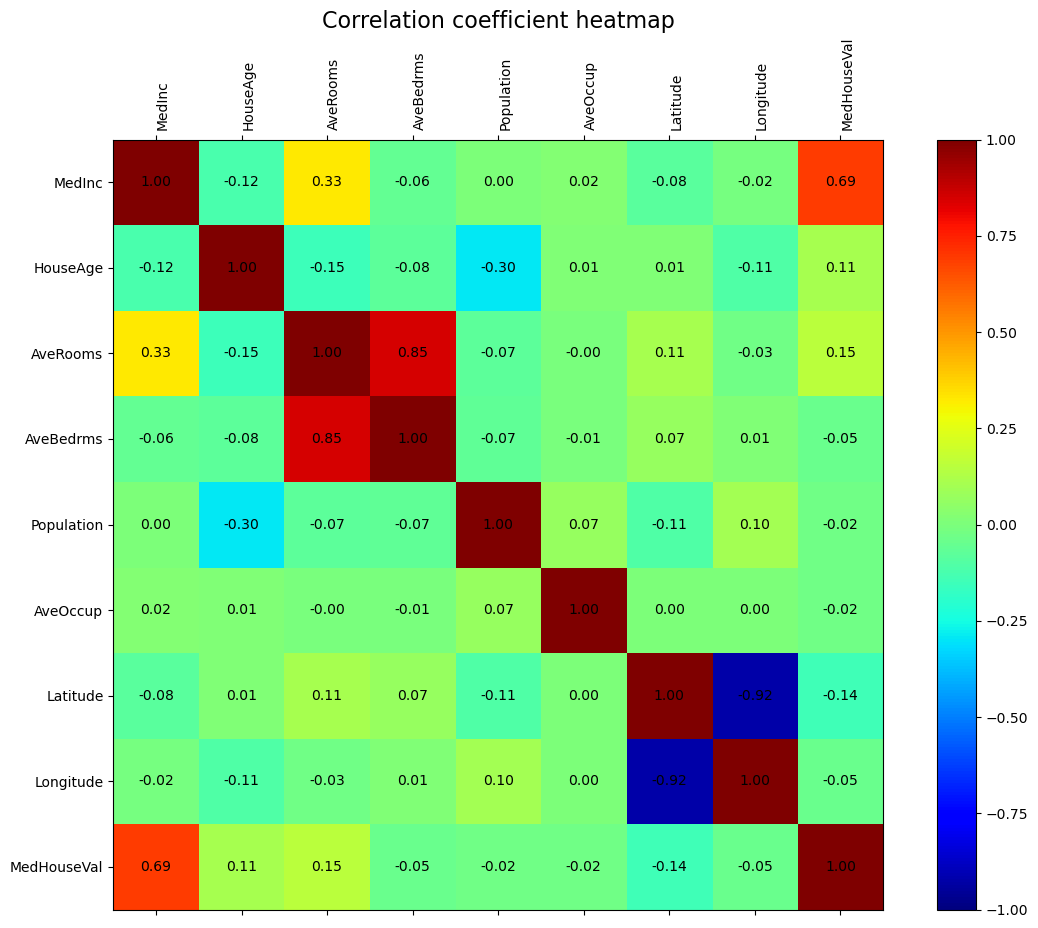

In [11]:
# calculate pearson coefficient matrix
corr = np.corrcoef(housing_df, rowvar=False)

# Show heat map
fig, ax = plt.subplots(figsize=(14,10))
plt.jet()

cax = ax.matshow(corr, vmin=-1, vmax=1)
plt.title("Correlation coefficient heatmap", fontsize=16)
fig.colorbar(cax)

for (i, j), c in np.ndenumerate(corr):
    ax.text(j, i, f"{c:.2f}", ha="center", va="center")

ticks = list(range(len(housing_df.columns)))
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(housing_df.columns, rotation=90, horizontalalignment='left')
ax.set_yticklabels(housing_df.columns)
plt.show()

Most features do not seem to correlate with each other. Interestingly, the median income of the district has a high correlation with its median house value. This likely is the result of expensive districts attracting high-income families, while less attractive districts are left to low-income families. For the sake of this research question, we assume that this is undesired bias (to some extent) and possibly the result of gentrification. When defining a distance measure, median income of a district will not weigh as heavily.

## Initial predictive model: Statistical parity
In this section we train a Gaussian Naive Bayes Classifier on the credit data without any regard for fairness. The Gaussian Naive Bayes model is chosen because of its simplicity and efficiency.

### Preprocessing
We start by performing preprocessing on the dataset. The Gaussian Naive Bayes works best on normal distributed data. Therefore, we perform a transformation to standardize the features. Nominal categories are one-hot encoded using dummy columns for each possible category. Eventually we only keep the best $k$ features based on the F-statistic, which is recommended.

In [12]:
ctf = ColumnTransformer(
    transformers=[
        (
            'encode_nominals',
            OneHotEncoder(),
            ['Ethnicity', 'Industry', 'Citizen']
        ), (
            'standard_scale',
            StandardScaler(),
            ['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income']
        ), (
            'pass',
            'passthrough',
            ['Gender', 'Married', 'BankCustomer', 'PriorDefault', 'Employed', 'DriversLicense']
        )
    ],
    remainder='drop' # remove other features
)

# select K best parameters based on F-test
skb = SelectKBest(f_regression)

The data is transformed using the above defined preprocessing. It is then split the dataset into training and test set. We use a stratification scheme that ensures a proportional representation of the target feature (approval) in the resulting test and training set.

In [13]:
credit_y = credit_df['Approved']
credit_X =  credit_df.drop('Approved', axis=1)

(
    credit_X_train,
    credit_X_test,
    credit_y_train,
    credit_y_test
) = train_test_split(
    credit_X, 
    credit_y, 
    test_size=0.25,
    random_state=0,
    shuffle=True,
    stratify=credit_y
)

### Model fitting
Here, the Gaussian Naive Bayes classifier is fit to the training data. To select the best amount of features, we perform a grid search. The grid search uses a 5-fold cross-validation to get the best hyperparameter.

In [14]:
credit_pipe = Pipeline([
    ('col_trans', ctf),
    ('k_best', skb),
    ('gnb', GaussianNB())
])

credit_params = {
    'k_best__k': np.linspace(10, 25, 10, dtype=int)
}

kfcv = KFold(n_splits=5, shuffle=True, random_state=0)

gnb_gs = GridSearchCV(
    credit_pipe, 
    credit_params,
    scoring='accuracy',
    refit=True,
    cv=kfcv,
    return_train_score=True
)

gnb_gs.fit(credit_X_train, credit_y_train)
for param, value in gnb_gs.best_params_.items():
    print(f'{param}: {value}')

k_best__k: 10


### Model performance and fairness assessment
Now that the model is fitted, we assess its performance on the test set.

In [15]:
def score_summary(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f'R^2: {r2:.2f}; MAE: {mae:.2f}; MSE: {mse:.2f}')

In [16]:
credit_y_test_pred = gnb_gs.predict(credit_X_test)
score_summary(credit_y_test_pred, credit_y_test)

R^2: 0.47; MAE: 0.13; MSE: 0.13


The fitted model has an accuracy of prediction is $1-\operatorname{MAE} = 0.87$, which is decent. We look at the predicted rates by ethnicity, both for the training set and test set. Also, we quantify the dependence using the dependence metric $\operatorname{dep}_{E = \mathrm{Latino}}$.

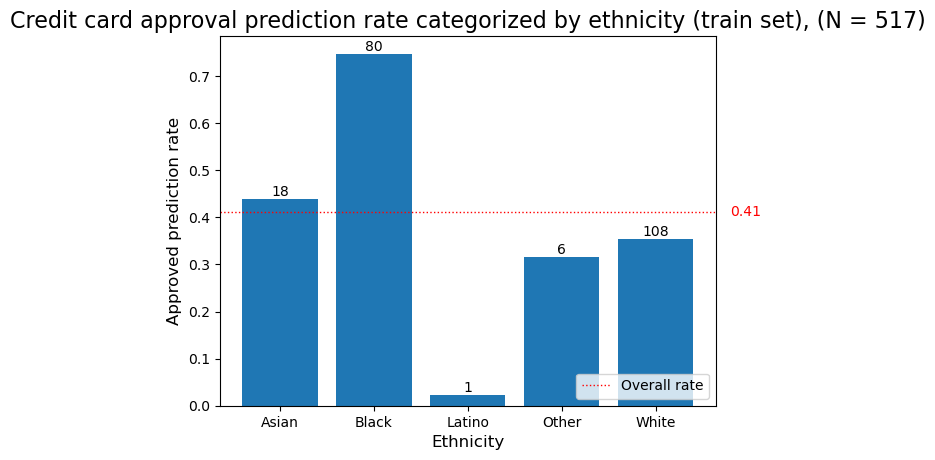

In [24]:
credit_y_train_pred = gnb_gs.predict(credit_X_train)

sensitive_rate_plot(
    credit_X_train['Ethnicity'],
    pd.Series(credit_y_train_pred, name='Approved prediction'),
    1,
    'Credit card approval prediction rate categorized by ethnicity (train set)'
)

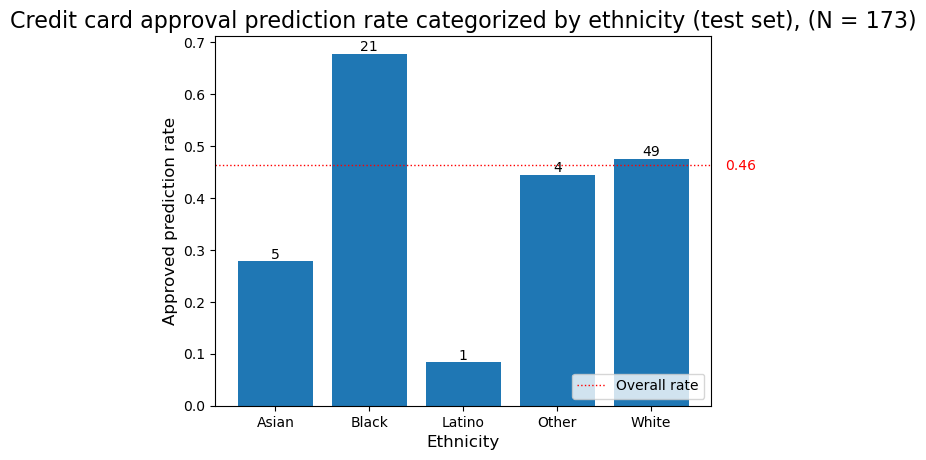

In [ ]:
sensitive_rate_plot(
    credit_X_test['Ethnicity'],
    pd.Series(credit_y_test_pred, name='Approved prediction'),
    1,
    'Credit card approval prediction rate categorized by ethnicity (test set)'
)

In [25]:
dep_latino_train = fairness_dependence_metric(
    credit_X_train['Ethnicity'],
    credit_y_train_pred,
    'Latino',
    1
)

dep_latino_test = fairness_dependence_metric(
    credit_X_test['Ethnicity'],
    credit_y_test_pred,
    'Latino',
    1
)

print(f'DEP on train: {dep_latino_train:.2f}; DEP on test: {dep_latino_test:.2f}')

DEP on train: 0.43; DEP on test: 0.41


The plots indicate the model is not fair with respect to statistical parity. The dependence metric reflects this bad fairness. It is as bad (and worse on the training data) than the initial dataset.

## Fair predictive model: Statistical parity
In this section we attempt to make the previous predictive model satisfy statistical parity. Calders et al. (2009) proposed two methods of doing so. **Massaging** reduces the dependency by changing the target feature in the dataset. Admittedly, this is intrusive. The **reweighing** approach associates weights to each combination of target classes with protected or non-protected groups. We will use the reweighing approach, as Gaussian Naive Bayes supports weighted samples.

### Preprocessing
We first start by constructing a modification to the preprocessing transformer. It no longer allows for ethnicity to be used in the model.

In [26]:
ctf_fair = ColumnTransformer(
    transformers=[
        (
            name,
            trans,
            list(filter(lambda col: col != 'Ethnicity', cols))
        )
        for name, trans, cols in ctf.transformers # has copy of unfitted transformer
    ]
)

Next, the weights for each sample is calculated. The following formula was derived from Calders et al. (2009), each sample $\vec{x} \in X$ with sensitive feature $S = s$ and target value $Y = y$ has weight:
$$W_{s, y} = \frac {|\{\vec{z} \in X \mid \vec{z}(S) = s\}|*|\{\vec{z} \in X \mid \vec{z}(Y) = y\}|} {|\{\vec{z} \in X \mid \vec{z}(S) = s, \vec{z}(Y) = y\}|*|X|}$$

In [27]:
def dependence_weights(df_x, df_y, protected_group, positive):
    prot_mask = df_x == protected_group
    pos_mask = df_y == positive

    n = len(df_y)
    
    n_prot = prot_mask.sum()
    n_pos = pos_mask.sum()
    n_nprot = n - prot_mask.sum()
    n_npos = n - pos_mask.sum()

    n_prot_pos = (prot_mask & pos_mask).sum()
    n_prot_npos = (prot_mask & ~pos_mask).sum()
    n_nprot_pos = (~prot_mask & pos_mask).sum()
    n_nprot_npos = (~prot_mask & ~pos_mask).sum()

    weights = np.ones(n)

    weights[prot_mask & pos_mask] = (n_prot * n_pos) / (n_prot_pos * n)
    weights[prot_mask & ~pos_mask] = (n_prot * n_npos) / (n_prot_npos * n)
    weights[~prot_mask & pos_mask] = (n_nprot * n_pos) / (n_nprot_pos * n)
    weights[~prot_mask & ~pos_mask] = (n_nprot * n_npos) / (n_nprot_npos * n)
    
    return weights

In [28]:
credit_weights = dependence_weights(
    credit_X_train['Ethnicity'],
    credit_y_train,
    'Latino',
    1
)

np.unique(credit_weights)

array([0.62451644, 0.93324737, 1.06080705, 4.00386847])

### Model fitting
The Gaussian Naive Bayes is fitted with the training data and weights. We also make sure to use preprocessing that excludes the ethnicity attribute.

In [30]:
credit_pipe_fair = Pipeline([
    ('col_trans', ctf_fair),
    ('k_best', skb),
    ('gnb', GaussianNB())
])

gnb_gs_fair = GridSearchCV(
    credit_pipe_fair, 
    credit_params,
    scoring='accuracy',
    refit=True,
    cv=kfcv,
    return_train_score=True
)

gnb_gs_fair.fit(
    credit_X_train, 
    credit_y_train,
    gnb__sample_weight=credit_weights
)
for param, value in gnb_gs_fair.best_params_.items():
    print(f'{param}: {value}')

k_best__k: 18


In [31]:
credit_y_test_pred_fair = gnb_gs_fair.predict(credit_X_test)
score_summary(credit_y_test_pred_fair, credit_y_test)

R^2: 0.26; MAE: 0.18; MSE: 0.18


The fitted model has an accuracy of prediction is $1-\operatorname{MAE} = 0.82$. This means the accuracy only went down by $5%$. Next, we look at the predicted rates by ethnicity again and calculate the dependence using the dependence metric $\operatorname{dep}_{E = \mathrm{Latino}}$.

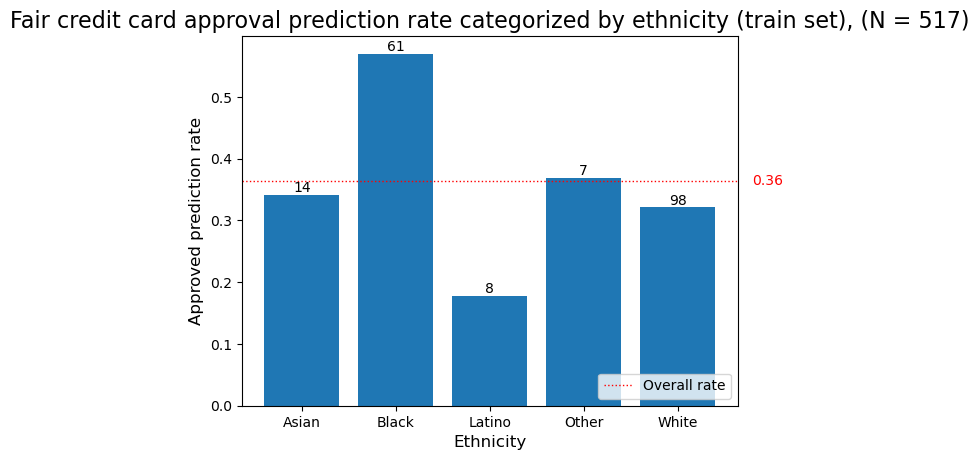

In [32]:
credit_y_train_pred_fair = gnb_gs_fair.predict(credit_X_train)

sensitive_rate_plot(
    credit_X_train['Ethnicity'],
    pd.Series(credit_y_train_pred_fair, name='Approved prediction'),
    1,
    'Fair credit card approval prediction rate categorized by ethnicity (train set)'
)

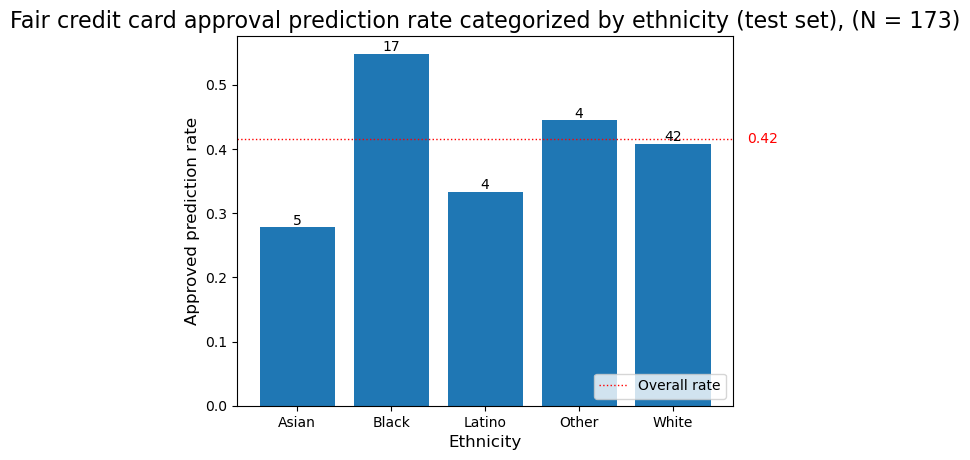

In [33]:
sensitive_rate_plot(
    credit_X_test['Ethnicity'],
    pd.Series(credit_y_test_pred_fair, name='Approved prediction'),
    1,
    'Fair credit card approval prediction rate categorized by ethnicity (test set)'
)

In [34]:
dep_latino_train = fairness_dependence_metric(
    credit_X_train['Ethnicity'],
    credit_y_train_pred_fair,
    'Latino',
    1
)

dep_latino_test = fairness_dependence_metric(
    credit_X_test['Ethnicity'],
    credit_y_test_pred_fair,
    'Latino',
    1
)

print(f'DEP on train: {dep_latino_train:.2f}; DEP on test: {dep_latino_test:.2f}')

DEP on train: 0.20; DEP on test: 0.09


The plots indicate much better fairness for the protected group. The dependence metric confirms this result: it is a fourth of the initial (unfair) model.

### Further improvements
The final *fair* model does not yield complete independence between the protected ethnicity group and credit card approval. Admittedly, complete independence might penalize the performance too much. From the plots it seems that Asians got penalized the most. Black people did not seem to be affected, while initially they seemed the most privileged subgroup. This might not be desirable. It raises an important problem with the statistical parity fairness notion. Striving for equal opportunities with this notion does not require the best of the (non-)protected subgroups. While maximizing overall performance does influence this, it does not take into account how accurate each group is represented. As a result, Dwork et al. (2012) concluded that statistical parity is not sufficient as a fairness notion. A more appropriate fairness notion is individual fairness (through awareness).

## Sources
* Barocas, S., Hardt, M., & Narayanan, A. (2017). Fairness in machine learning. Nips tutorial, 1, 2017.
* Calders, T., Kamiran, F., & Pechenizkiy, M. (2009, December). Building classifiers with independency constraints. In *2009 IEEE international conference on data mining workshops* (pp. 13-18). IEEE.
* Chouldechova, A., & Roth, A. (2018). The frontiers of fairness in machine learning. *arXiv preprint arXiv:1810.08810*.
* Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
* Dwork, C., Hardt, M., Pitassi, T., Reingold, O., & Zemel, R. (2012, January). Fairness through awareness. In *Proceedings of the 3rd innovations in theoretical computer science conference* (pp. 214-226).
* Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297.